# Hayden Johnson
# Econ 409 Forecasting Homework #2

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import io
import datetime
import matplotlib.lines as mlines
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as st
import warnings

In [2]:
data = pd.read_csv('hw2_data.csv', parse_dates = True, index_col = 0)[["I_US", "I_EU"]]

In [3]:
data.head()

I_US    I_EU
2003-12-01  1.11  2.1590
2004-01-01  1.10  2.1463
2004-02-01  1.06  2.0895
2004-03-01  1.05  2.0706
2004-04-01  1.05  2.0288

## 1

**a)**

In [4]:
interest = data[['I_US','I_EU']].copy()

In [5]:
exrate = pd.read_csv("hw2_data.csv",parse_dates = True, index_col = 0)[["Euro"]]
exrate.head()

Euro
2003-12-01  1.196501
2004-01-01  1.258194
2004-02-01  1.246805
2004-03-01  1.244803
2004-04-01  1.236507

Text(0.5, 1.0, 'US Interbank Rate')

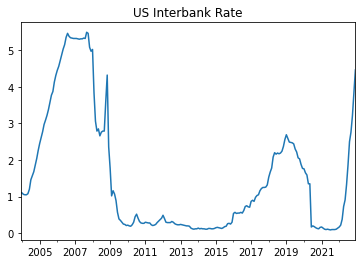

In [6]:
interest['I_US'].dropna().plot()
plt.title('US Interbank Rate')

In [7]:
# Implement min max scaling in a function
def scale(x):
    return (x-x.min())/(x.max()-x.min())

# Apply Scaling
interest["ir_diff"] = scale(interest["I_US"]) - scale(interest["I_EU"])
interest.dropna(inplace= True)

<AxesSubplot:title={'center':'Interest Rate Differential With Scaling'}>

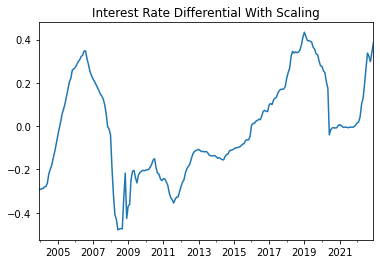

In [8]:
plt.title("Interest Rate Differential With Scaling")
interest["ir_diff"].plot()

**b)**

In [9]:
# Below are teh two sets of parameters that I used to generate the visualizations you see in the slides

# No CI version
k = 0.43
z = 1.645
T = 20

#changing K
#k = 0.88
#z = 1.645
#T = 20

#changing Z
#k = 0.43
#z = 8.645
#T = 20

#changing T
#k = 0.43
#z = 5.645
#T = 800

# This implements the kalman filter in python
# It is simple otherwise to create using a for loop
interest["Filter"] = interest.ir_diff.ewm(alpha = k, adjust = False).mean()

# Compute the filter error
interest["Filter Error"] = interest.ir_diff - interest["Filter"]

**c)**

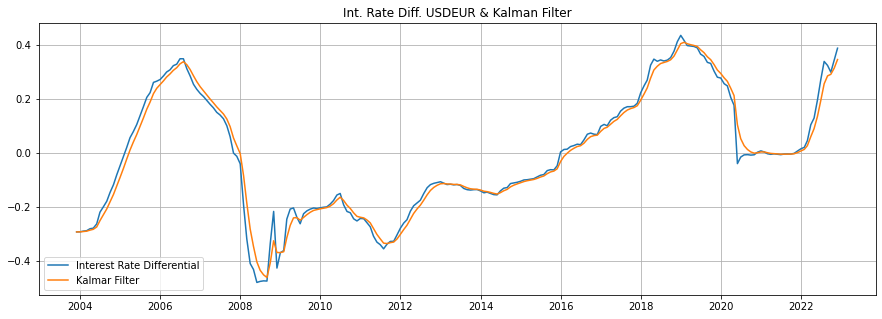

In [10]:
plt.figure(figsize = (15, 5))

plt.title("Int. Rate Diff. USDEUR & Kalman Filter")

#plotting the USDEURO interest rate differential
plt.plot(interest['ir_diff'])
#plotting the Kalman Filter
plt.plot(interest['Filter'])

#Creating an easily readable legend
plt.legend(["Interest Rate Differential", "Kalmar Filter"]) 
#plt.xlim([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1)])
plt.grid()

In [11]:
int2 = interest[["ir_diff", "Filter", "Filter Error"]].copy()

# get the sample mean at each point in time using an expanding window
int2["E_bar"] = int2["Filter Error"].expanding(T).mean()

# get the sample mean at each point in time using a rolling window
int2["mu_t"] = int2["Filter Error"].rolling(T).mean()

# get the variance at each point in time using an expanding window
int2["var_t"] = int2["Filter Error"].expanding(T).std()

# calculate the test statistic
int2["Test Statistic"] = int2["mu_t"]/(int2["var_t"]/np.sqrt(T))

# create a new coluimn with a 0 default value
int2["Signal"] = 0
for i in int2.index:
    # create signals based on the sign of the current mean and if we fail to reject the null
    if (int2.loc[i, "Test Statistic"] < z) & (int2.loc[i, "E_bar"] >= 0):
        int2.loc[i, "Signal"] = 1
    elif (int2.loc[i, "Test Statistic"] > -z) & (int2.loc[i, "E_bar"] < 0):
        int2.loc[i, "Signal"] = -1

int2.dropna(inplace = True)
int2.head()

ir_diff    Filter  Filter Error     E_bar      mu_t     var_t  \
2005-07-01  0.136397  0.096988      0.039408  0.025808  0.025808  0.017592   
2005-08-01  0.170107  0.128429      0.041678  0.026564  0.027892  0.017493   
2005-09-01  0.204844  0.161287      0.043556  0.027336  0.030059  0.017451   
2005-10-01  0.222203  0.187481      0.034722  0.027658  0.031716  0.017120   
2005-11-01  0.260255  0.218774      0.041481  0.028234  0.033703  0.016979   

            Test Statistic  Signal  
2005-07-01        6.560854       0  
2005-08-01        7.130834       0  
2005-09-01        7.703085       0  
2005-10-01        8.285206       0  
2005-11-01        8.876982       0

In [12]:
int2.Signal.value_counts()

 1    126
 0     76
-1      8
Name: Signal, dtype: int64

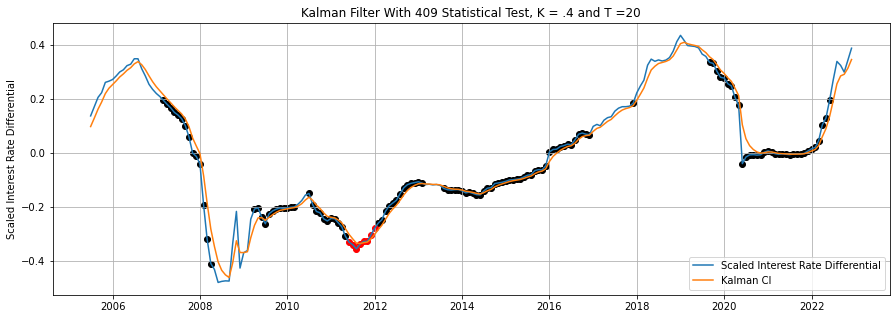

In [13]:
#interest2 = interest2[interest2.index.year >= 2017]
fig, ax = plt.subplots(figsize = (15, 5))
ax.set_title("Kalman Filter With 409 Statistical Test, K = .4 and T ="+str(T))

ax.set_ylabel("Scaled Interest Rate Differential")
ax.plot(int2["ir_diff"])
ax.plot(int2["Filter"])



ax.scatter(int2[int2.Signal == 1].index, int2[int2.Signal == 1]["ir_diff"], color = "black")
ax.scatter(int2[int2.Signal == -1].index, int2[int2.Signal == -1]["ir_diff"], color = "red")

ax.legend(["Scaled Interest Rate Differential", "Kalman CI"])


#plt.xlim([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1)])
ax.grid()

# 2

**a)**

In [14]:
# Create a dataframe at a daily frequency wiyh start and end 
# dates that cover the observation period
drange = pd.date_range(start =interest.index[0], end = "2022-12-01")
daily  = pd.DataFrame(index = drange)

daily["Signal"] = int2["Signal"]

daily["Filter"] = int2["Filter"]

daily["Filter"] = daily["Filter"].ffill()

daily["ir_diff"] = int2["ir_diff"]
daily["ir_diff"] = daily["ir_diff"].ffill()
daily = daily.fillna(0)

i = 30
daily[str(i)+"_signal"] = 0
for j in daily.index:
    if daily.loc[j,"Signal"] != 0:
        daily.loc[j:j+datetime.timedelta(i), str(i)+"_signal"] = daily.loc[j, "Signal"]

In [15]:
drange = pd.date_range(start =int2.index[0], end = "2022-12-01")
exdf = pd.DataFrame(index = drange)

exdf["EURUSD"] = exrate
exdf["EURUSD"] = exdf["EURUSD"].ffill()

daily["EURUSD"] = exdf["EURUSD"]
daily["Returns"] = np.log(daily["EURUSD"]).diff()

In [16]:
s = i
daily[str(s)+"_returns"] = (np.exp((daily[str(i)+"_signal"].shift()*daily.Returns).cumsum())-1)

In [17]:
daily[str(s)+"_success"] = ((daily[daily.Signal!= 0][str(s)+"_returns"].diff()>0)*1).shift(-1)
daily.head()

Signal  Filter  ir_diff  30_signal  EURUSD  Returns  30_returns  \
2003-12-01     0.0     0.0      0.0          0     NaN      NaN         NaN   
2003-12-02     0.0     0.0      0.0          0     NaN      NaN         NaN   
2003-12-03     0.0     0.0      0.0          0     NaN      NaN         NaN   
2003-12-04     0.0     0.0      0.0          0     NaN      NaN         NaN   
2003-12-05     0.0     0.0      0.0          0     NaN      NaN         NaN   

            30_success  
2003-12-01         NaN  
2003-12-02         NaN  
2003-12-03         NaN  
2003-12-04         NaN  
2003-12-05         NaN

The Null hypothesis of the test is that the current mean is different from the sample mean. Therefore if we fail to reject the null hypothesis, then we expect the direction to change. 

So if $\bar{\epsilon} <0$ and we fail to reject the null hypothesis, then we think that the current errors are greater than 0. This means that the interest rate differential is rising and we should therefor enter a short position in the yen.

So if $\bar{\epsilon} >0$ and we fail to reject the null hypothesis, then we think that the current errors are less than 0. This means that the interest rate differential is rising and we should therefor enter a long position in the yen.

**b)**

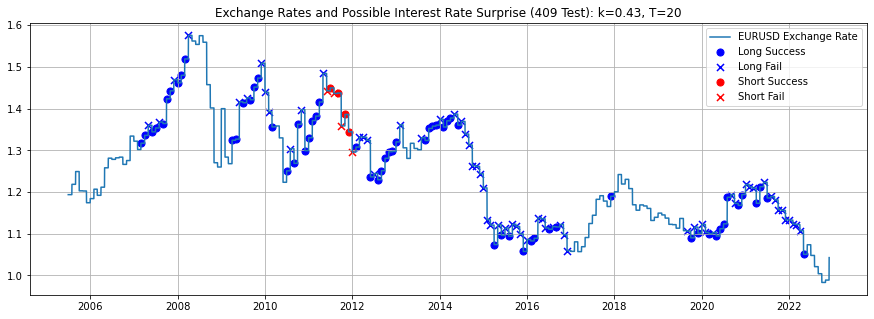

In [18]:
plt.figure(figsize = (15, 5))

plt.title("Exchange Rates and Possible Interest Rate Surprise (409 Test):"+ " k=" + str(k)+", T="+str(T))

plt.plot(daily["EURUSD"])

longsuccess = daily[(daily[str(s)+"_success"] == 1) & (daily["Signal"] == 1)]
longfail = daily[(daily[str(s)+"_success"] == 0) & (daily["Signal"] == 1)] 
shortsuccess = daily[(daily[str(s)+"_success"] == 1) & (daily["Signal"] == -1)]
shortfail = daily[(daily[str(s)+"_success"] == 0) & (daily["Signal"] == -1)]

plt.scatter(longsuccess.index, longsuccess["EURUSD"], color = 'blue', s = 50)
plt.scatter(longfail.index, longfail["EURUSD"], color = 'blue', s = 50, marker = "x")

plt.scatter(shortsuccess.index, shortsuccess["EURUSD"], color = 'red', s = 50)
plt.scatter(shortfail.index, shortfail["EURUSD"], color = 'red', s = 50, marker = "x")

plt.legend(["EURUSD Exchange Rate", "Long Success", "Long Fail", "Short Success", "Short Fail"])
#plt.xlim([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1)])
plt.grid()

In [19]:
mret = str(i)+"_returns"

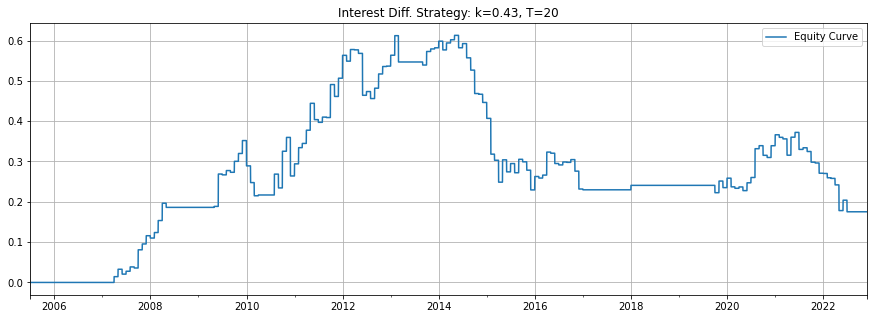

In [20]:
plt.figure(figsize = (15, 5))
d2 = daily[daily.index.year >= 2020]
(daily[mret].dropna()).plot()

plt.title("Interest Diff. Strategy:"+ " k=" + str(k)+", T="+str(T))



plt.legend(["Equity Curve", "Long Success", "Long Fail", "Short Success", "Short Fail"])

plt.grid()
#plt.xlim(["1/1/2019", "1/1/2022"])

**c)**

In [21]:
start = daily[["EURUSD", mret, "30_signal"]][123:].index[0]

df = daily[daily.Signal != 0][["30_signal", "EURUSD"]].copy()
df['D'] = df["30_signal"]

In [22]:
df = df[:-2].copy()

In [23]:
df = df[:-2].copy()
df['s_current'] = daily[daily.index.isin(df.index)]["EURUSD"].values
df['s_future'] = daily[daily.index.isin(df.index+datetime.timedelta(30))]["EURUSD"].values
#switched 41 to 30 on timedelta because that is what I used for "i"

# Getting the realized exchange rate
df['R'] = np.where(df['s_future'] >= df['s_current'], 1, -1)

In [24]:
## Sample Covariance
df['W'] = (df['D']-np.mean(df['D']))*(df['R']-np.mean(df['R']))
T_B = np.mean(df['W'])

In [43]:
df

30_signal    EURUSD  D  s_current  s_future  R         W       W_2
2007-03-01          1  1.317003  1   1.317003  1.317003  1  0.049231  0.000000
2007-04-01          1  1.335898  1   1.335898  1.360100  1  0.049231  0.024202
2007-05-01          1  1.360100  1   1.360100  1.360100  1  0.049231  0.000000
2007-06-01          1  1.344194  1   1.344194  1.353601  1  0.049231  0.009407
2007-07-01          1  1.353601  1   1.353601  1.353601  1  0.049231  0.000000
...               ...       ... ..        ...       ... ..       ...       ...
2021-10-01          1  1.157448  1   1.157448  1.157448  1  0.049231  0.000000
2021-11-01          1  1.155668  1   1.155668  1.133029 -1 -0.196923 -0.022640
2021-12-01          1  1.133029  1   1.133029  1.133029  1  0.049231  0.000000
2022-01-01          1  1.132503  1   1.132503  1.132503  1  0.049231  0.000000
2022-02-01          1  1.122965  1   1.122965  1.121592 -1 -0.196923 -0.001373

[130 rows x 8 columns]

In [25]:
T_B

0.012307692307692398

In [26]:
## Newey-West LRV estimator
dy = df['W'] - np.mean(df['W'])
gamma_0 = sum((dy)**2)/len(df)
gamma_1 = np.mean((dy*dy.shift(-1))[:len(df)-1])
LRV = gamma_0 + 2*(1-1/2)*gamma_1

In [27]:
## Test-statistic
from scipy.stats import norm

statistic = T_B/np.sqrt(LRV/df.shape[0])
print('Test statistic : ', statistic, ', 5 % critical value : ', round(norm.ppf(0.95),2))

Test statistic :  0.4158177763593187 , 5 % critical value :  1.64


Fail to reject the null hypothesis.

In [28]:
# Weighted Mean
df['W_2'] = df['D']*(df['s_future']-df['s_current'])
T_WB = np.mean(df['W_2'])

In [29]:
T_WB

0.002000841727623571

In [30]:
## Newey-West LRV estimator
dy_2 = df['W_2'] - np.mean(df['W_2'])
gamma_0 = sum((dy_2)**2)/len(df)
gamma_1 = np.mean((dy_2*dy_2.shift(-1))[:len(df)-1])
LRV_2 = gamma_0 + 2*(1-1/2)*gamma_1

In [31]:
## Test-statistic
statistic_2 = T_WB/np.sqrt(LRV_2/len(df))
print('Test statistic : ', statistic_2, ', 5 % critical value : ', round(norm.ppf(0.95),2))

Test statistic :  1.0533178517612802 , 5 % critical value :  1.64


Fail to reject the null hypothesis

**d)**

As K approaches zero, the interest rate differential curve found itself moving further away from the Kalman Filter. The higher the K, the more closer together the two lines became. Changing T makes the strategy vunerable to volatility when T decreases. The strategy is not very robust. Increasing T caused the mean to be more robust and less sensitive to outliers. Increasing Z lead to more false-negatives than we would like and decreasing Z produced more false-positives than we would like.

# 3

**a)**

In [32]:
def ytm(fv, n, c, r, pv):
    return ((c+((fv-pv)/n))/((fv+pv)/2))

In [33]:
print(str(round((100*ytm(1000,10,50,.01, 984.94)),3)) + '%')

5.19%


**b)**

In [34]:
(.8*1000)/(1.01)

792.0792079207921

# 4

In [35]:
def cashFlow(fv, n, c):
    C = fv*c
    cfLst = list()
    for i in range(n-1):
        cfLst.append(C)
    cfLst.append(fv + C)
    return cfLst

In [36]:
def discountFactor(n, r):
    dfLst = list()
    for i in range(1, n+1):
        dfLst.append(1/((1+r)**i))
    return dfLst

In [37]:
def numerator(fv, n, c, r):
    cfLst = cashFlow(fv, n, c)
    dfLst = discountFactor(n, r)
    total = 0.0
    for i in range(1, n+1):
        total += (i*cfLst[i-1]*dfLst[i-1])
    return total

In [38]:
def denominator(fv, n, c, r):
    C = fv*c
    denom = 0.0
    for i in range (1, n):
        denom = denom + (C/((1 + r)**i))
    denom += ((C+fv)/((1 + r)**n))
    return denom

In [39]:
def duration(fv, n, c, r):
    num = numerator(fv, n, c, r)
    denom = denominator(fv, n, c, r)
    return num/denom

**a)**

In [40]:
print('The duration for a 10-year, 15% coupon bond with interest rate of 10%: ' + str(duration(1000, 10, .15, .1)))

The duration for a 10-year, 15% coupon bond with interest rate of 10%: 6.281090250274969


In [41]:
print('The duration for a 7-year, 3% coupon bond with interest rate of 3%: ' + str(duration(1000, 7, .03, .03)))

The duration for a 7-year, 3% coupon bond with interest rate of 3%: 6.417191443878188


The 7-year bond has a higher duration. The higher the duration, the higher risk the bond is to interest rates. The bond's price will drop if interest rates rise, so the 7-year bond is riskier in terms of interest rates.

**b)**

We expect the price of the 7-year bond's price to change greater than the 10-year bond because it has a higher duration. The price will drop further than the 10-year bond when we increase the interest rate by 1% because it has a higher interest rate risk.

**c)**

In [42]:
print('The duration of the portfolio is: ' + str(.7*duration(1000, 10, .15, .1) + .3*duration(1000, 7, .03, .03)))

The duration of the portfolio is: 6.321920608355934


# 5

**a)**

The ECB raised interest rates in December by 50 basis points because the substantial upward revision to the inflation outlook. In particular, they judged that interest rates would still have to rise significantly at a steady pace to reach levels that are sufficiently restrictive to ensure a timely return of inflation to their two per cent medium-term target. In February the ECB continued to raise rates by 50 basis points to ensure a timely return of inflation to their two per cent medium-term target. They plan to raise rates another 50 basis points in March. Inflation is still not reaching levels the ECB wants. Not much has changed between December and February.

The Fed referenced the war in Ukraine as causing inflation risks. Furthermore, they want to return inflation to its 2% target. Therefore, they raised the Federal Funds rate by a quarter of a percent in December. In February, they issued an almost identitical statement referencing about the Ukraine war causing inflation risks. Inflation is not coming down to their 2% target, just like in December, so they raised the Federal Funds rate by another quarter of a percent.

**b)**

The strong job market is quite unexpected. Unemployment is very low with inflation being high and a recession looming overhead. Even with all the tech layoffs, unemployment remains low. The conflict in Ukraine has been going on for almost a year now. However, not reaching an agreement is quite unexpected. All this contributes to inflation from decreasing, leading the banks to raise interest rates again.

**c)**

Europe was a big buyer of Russian oil and natural gas, more so than the US. With the rate hikes in the cost of energy, the Euro depreciated. The ECB was also slower to react to inflation pressures compared to the US. The US has a stronger currency because of how aggressively it fought and still fights inflation. Foreign investor want to invest in a place with higher interest rates, further devauling the Euro.

# 6

I believe Fed chairman Jerome Powell said it well that his job is to bring inlation to 2%. He worked in the finance industry and they can make their predictions, but the Fed will do whatever it takes to bring inflation down. The inflation rate should be the Fed's focus and they need not be deterred from what the market says. The Fed is not there to appease people and make them rich from their gambles. With access to the stock markets being easier than ever, many stockholders are speculators and not intelligent investors. They do not do their thorough research and react to what others are doing. The Fed should follow my reccomendation because inflation needs to be curbed for a healthy economy, not a rising stock market.